# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you an indication of whether a species might be a "keystone" species and therefore have a disproportionatly large impact.

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GloBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GloBI (https://curiositydata.org/part1_globi_access/).


### For information: This is the list of invasive alien species of Union concern
|A|H|O|
|--|--|--|
|Acacia saligna|Heracleum sosnowskyi|Orconectes virilis|
|Acridotheres tristis|Herpestes javanicus|Oxyura jamaicensis|
|Ailanthus altissima|Humulus scandens|Pacifastacus leniusculus|
|Alopochen aegyptiaca|Hydrocotyle ranunculoides|Parthenium hysterophorus|
|Alternanthera philoxeroides|Impatiens glandulifera|Pennisetum setaceum|
|Andropogon virginicus|Lagarosiphon major|Perccottus glenii|
|Arthurdendyus triangulatus|Lepomis gibbosus|Persicaria perfoliata|
|Asclepias syriaca|Lespedeza cuneata|Plotosus lineatus|
|Baccharis halimifolia|Lithobates catesbeianus|Procambarus clarkii|
|Cabomba caroliniana|Ludwigia grandiflora|Procambarus fallax|
|Callosciurus erythraeus|Ludwigia peploides|Procyon lotor|
|Cardiospermum grandiflorum|Lygodium japonicum|Prosopis juliflora|
|Cortaderia jubata|Lysichiton americanus|Pseudorasbora parva|
|Corvus splendens|Microstegium vimineum|Pueraria montana|
|Ehrharta calycina|Muntiacus reevesi|Salvinia molesta|
|Eichhornia crassipes|Myocastor coypus|Sciurus carolinensis|
|Elodea nuttallii|Myriophyllum aquaticum|Sciurus niger|
|Eriocheir sinensis|Myriophyllum heterophyllum|Tamias sibiricus|
|Gunnera tinctoria|Nasua nasua|Threskiornis aethiopicus|
|Gymnocoronis spilanthoides|Nyctereutes procyonoides|Trachemys scripta|
|Heracleum mantegazzianum|Ondatra zibethicus|Triadica sebifera|
|Heracleum persicum|Orconectes limosus|Vespa velutina|

In [288]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [289]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ
import sqlite3
from sqlite3 import Error
import pydot

### Setting up some parameters

In [290]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and birds
thresholdForOccNum = 5
# If you want to exclude an interaction add it here
#interactionsToExclude = "interactsWith"
interactionsToExclude = ""

In [291]:

## Define the country of interest
country  = 'BE'

## Define the year from where to consider records for the occupancy
year = 1970

## Define the place to find the data cube for occupancy data
## Currently the cube contains only Belgian data so that is all that can be used
database = r"..\data\cube.db" 

## Define the place to find the interaction data
globiDB = r"..\..\batty\data\globi.db"

### Define the key taxon for the notebook for which to find all interactions


In [292]:
#taxon = "Oxalis corniculata" #creeping woodsorrel
#taxon = "Oxalis pes-caprae" #Bermuda buttercup
#taxon = "Abramis brama" #common bream
#taxon = "Dikerogammarus villosus" #killer shrimp
#taxon = "Lantanophaga pusillidactyla" #lantana plume moth
#taxon = "Lantana camara" #common lantana
#taxon = "Cirsium vulgare" #spear thistle
#taxon = "Solenopsis invicta" #red imported fire ant
#taxon = "Linepithema humile" #Argentine ant
#taxon = "Procyon lotor" # raccoon
#taxon = "Carpobrotus edulis" #Hottentot-fig
#taxon = "Sciurus carolinensis" # Eastern grey squirrel
#taxon = "Pipistrellus pipistrellus" # Common Pipistrelle
#taxon = "Rousettus aegyptiacus" #Egyptian fruit bat
#taxon = "Ailanthus altissima" #tree of heaven
#taxon = "Triturus carnifex" #Italian crested newt
#taxon = "Xenopus laevis" #African clawed frog
#taxon = "Rhinella marina" #cane toad
#taxon = "Cynops pyrrhogaster" #Japanese Newt
#taxon = "Pachytriton labiatus" #paddle-tail newt
#taxon = "Pleurodeles waltl" #Iberian ribbed newt
#taxon = "Podarcis sicula" #Italian wall lizard

taxon=input()


Acridotheres tristis


In [293]:
taxon = taxon.strip()

## Check to see if the taxon exits in GBIF

In [294]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [295]:

print('The taxon to be studied is ' + match['scientificName'])

The taxon to be studied is Acridotheres tristis (Linnaeus, 1766)


### Just for information take a look at the interactions that the taxon has

In [296]:
# What are all the types of interactions involving taxon as source taxon?
#data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()
try:
    connGlobi = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [297]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName from globi  WHERE sourceTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
interactDataTaxon = curGlobi.fetchall()

In [298]:
interactDataTaxon

[('eats',), ('interactsWith',), ('preysOn',), ('visitsFlowersOf',)]

In [299]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName from globi  WHERE targetTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
interactDataTaxon = curGlobi.fetchall()
interactDataTaxon

[('eats',),
 ('ectoparasiteOf',),
 ('endoparasiteOf',),
 ('hasHost',),
 ('interactsWith',),
 ('parasiteOf',)]

## Get the primary interation data for the species in question

This is limited to the rank of species because otherwise the network can get very large with rather irrelivent higher taxa.
However, if no interactions are found at the species level it might be worth removing this restriction.

In [300]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE targetTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
interactDataTaxon = curGlobi.fetchall()

In [301]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE sourceTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
sources = curGlobi.fetchall()

In [302]:
interactDataTaxon.extend(sources)
len(interactDataTaxon)

77

In [303]:
# Convert to a Pandas dataframe
interactDataTaxon = pd.DataFrame(interactDataTaxon)

In [304]:
# Add column names
interactDataTaxon
interactDataTaxon.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName', \
                                'sourceSexId', 'sourceSexName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName',\
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

## Get a list of all the primary interacting species

In [305]:
interactingTaxaData = interactDataTaxon.drop_duplicates()

In [306]:
primaryInteractingTaxa = interactingTaxaData['sourceTaxonName'].drop_duplicates()
len(primaryInteractingTaxa)

22

In [307]:
primaryInteractingTaxa = (primaryInteractingTaxa.append(interactingTaxaData['targetTaxonName']).drop_duplicates())
len(primaryInteractingTaxa)

37

In [308]:
primaryInteractingTaxa

0                 Falco peregrinus
1          Menacanthus eurysternus
3                Myrsidea invadens
4                 Brueelia chayanh
5                        Rallicola
6            Sturnidoecus fragilis
8             Brueelia fuscopleura
9              Sturnidoecus bannoo
11               Myrsidea chilchil
12              Oxyspirura mansoni
14          Variolepis farciminosa
15                           Acari
19                   Anous minutus
20                Loxops coccineus
30     Plagiorhynchus cylindraceus
31                  Plagiorhynchus
32                         Dilepis
33                      Oxyspirura
35        Mediorhynchus orientalis
36       Choanotaenia magnicirrosa
37            Acridotheres tristis
62    Acridotheres tristis tristis
38                Corvus splendens
39                  Lantana camara
40             Spodoptera mauritia
41                Felis silvestris
42                    Homo sapiens
43             Herpestes javanicus
44                  

## A function to query the globi database

In [309]:
def secondaryDataInGlobi(conn, intaxon):
    cur = conn.cursor()
    if interactionsToExclude == "":
        cur.execute("SELECT * from globi  WHERE (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?);", \
                 (intaxon,intaxon,))
    else:
        cur.execute("SELECT * from globi where (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?) and interactionTypeName NOT IN (?);", \
                (intaxon,intaxon,interactionsToExclude,))
    return(cur.fetchall())

## Get all the secondary interactions

In [310]:
try:
    conn = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [311]:
secondarylist = []

for name in primaryInteractingTaxa:
    temp = secondaryDataInGlobi(conn, name)
    secondarylist.extend(temp)

In [312]:
# Convert to a Pandas dataframe
secondarylist = pd.DataFrame(secondarylist)

In [313]:
secondarylist.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName',\
                                'sourceSexId', 'sourceSexName', 'interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName', \
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

In [314]:
allInteractionsData = interactingTaxaData.append(secondarylist)

In [315]:
allInteractionsData = allInteractionsData.drop_duplicates()


In [316]:
    cleanInteractDataTaxon = allInteractionsData[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonSpeciesName', 'sourceTaxonRank',
       'sourceTaxonFamilyName', 'interactionTypeName',
       'targetTaxonName','targetTaxonSpeciesName','targetTaxonRank', 'sourceCitation', 'sourceDOI'
        ]].dropna(subset=['targetTaxonSpeciesName','sourceTaxonSpeciesName'])

In [317]:
allSourceInteractingTaxa = cleanInteractDataTaxon['sourceTaxonSpeciesName'].drop_duplicates()
allTargetInteractingTaxa = cleanInteractDataTaxon['targetTaxonSpeciesName'].drop_duplicates()

In [318]:
allInteractingTaxa = allSourceInteractingTaxa.append(allTargetInteractingTaxa).drop_duplicates()
allInteractingTaxa.count()

3717

In [319]:
allInteractingTaxa.head()

0           Falco peregrinus
1    Menacanthus eurysternus
3          Myrsidea invadens
4           Brueelia chayanh
5                           
dtype: object

In [320]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
hasHost                  67903
pathogenOf                8157
interactsWith             3746
eats                      3081
parasiteOf                2060
visitsFlowersOf            515
ectoparasiteOf             342
preysOn                    164
endoparasiteOf             102
pollinates                  45
mutualistOf                 34
hasDispersalVector          23
symbiontOf                  20
hasVector                   12
ecologicallyRelatedTo        4
livesOn                      3
guestOf                      2
livesInsideOf                2
visits                       1
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [321]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [322]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [323]:
taxaFound = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in allInteractingTaxa.items():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        taxaFound[name[1]] = False
        print(name[1])
    else:
        taxaFound[name[1]] = GBIFName['usageKey']
    

Taxa from GLoBI, but not found in GBIF

Falcon adenovirus A
Gammacoronavirus Avian coronavirus
Graphium choredon
NPV
Feline panleukopenia virus
Rabies virus
Alphacoronavirus
Felid herpesvirus 1
Betacoronavirus Severe acute respiratory syndrome-related coronavirus
Betacoronavirus Human coronavirus HKU1
Human coronavirus NO
Alphacoronavirus Human coronavirus NL63
Alphacoronavirus Human coronavirus 229E
unidentified human coronavirus
Betacoronavirus Middle East respiratory syndrome-related coronavirus
Human coronavirus Feline-like Hu142
Glomerella
Okadaella gastrococcus
Graphium
Human adenovirus G
Madrid virus
Chapare virus
Duvenhage virus
Human herpesvirus 2
Human enterovirus A
Human papillomavirus
Human herpesvirus 7
Human rhinovirus B
Human adenovirus D
Human rhinovirus A
Human rhinovirus C
Human parechovirus
Human herpesvirus 3
Human parvovirus B19
Human herpesvirus 5
BK polyomavirus
Human enterovirus D
Human adenovirus A
Human parainfluenza virus 2
Human parainfluenza virus 4
Human a

In [324]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [325]:
len(taxaFound)

3717

In [326]:
taxaFound

,0
Falco peregrinus,2481047
Menacanthus eurysternus,1032840
Myrsidea invadens,6935363
Brueelia chayanh,6937596
,False
Sturnidoecus fragilis,6940105
Brueelia fuscopleura,4422081
Sturnidoecus bannoo,6940082
Myrsidea chilchil,6935306
Oxyspirura mansoni,4557028


### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [327]:
def speciesCountInCube(conn, key):
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [328]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [329]:
year

1970

In [330]:
for GBIFtaxon in taxaFound.iterrows():
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    print(GBIFtaxon[0])
    if GBIFOccCount[0][0] > thresholdForOccNum and GBIFtaxon[0] != taxon: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))
    elif GBIFtaxon[0] == taxon:
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))

Falco peregrinus
Falco peregrinus with key 2481047 occurs in 10490 km squares.
Menacanthus eurysternus
Myrsidea invadens
Brueelia chayanh

Sturnidoecus fragilis
Brueelia fuscopleura
Sturnidoecus bannoo
Myrsidea chilchil
Oxyspirura mansoni
Variolepis farciminosa
Anous minutus
Loxops coccineus
Plagiorhynchus cylindraceus
Mediorhynchus orientalis
Choanotaenia magnicirrosa
Acridotheres tristis
Acridotheres tristis with key 2489005 occurs in 10 km squares.
Falco rusticolus
Falco rusticolus with key 8069880 occurs in 102 km squares.
Myiopsitta monachus
Myiopsitta monachus with key 2479407 occurs in 109 km squares.
Vulpes vulpes
Vulpes vulpes with key 5219243 occurs in 50 km squares.
Colpocephalum falconii
Nosopon lucidum
Degeeriella rufa
Cladotaenia circi
Falcon adenovirus A
Mycoplasma buteonis
Influenza A virus
Leucophaeus pipixcan
Leucophaeus pipixcan with key 5846430 occurs in 88 km squares.
Actitis macularius
Actitis macularius with key 2481798 occurs in 34 km squares.
Rynchops niger
Ath

Pieris rapae
Pieris rapae with key 1920496 occurs in 15284 km squares.
Chlorostilbon alice
Theagenes dichrous
Ortilia ithra
Bombus pauloensis
Papilio astyalus
Copaeodes minima
Epargyreus tmolis
Vanessa carye
Heliconius hewitsoni
Melete polyhymnia
Heliconius erato
Colias eurytheme
Tirumala limniace
Actinote pellenea
Papilio eurymedon
Papilio thoas
Papilio machaon
Papilio machaon with key 8225376 occurs in 9429 km squares.
Vanessa braziliensis
Archilochus colubris
Xylocopa virginica
Parides bunichus
Poanes melane
Megalographa biloba
Autochton pseudocellus
Proteides mercurius
Emesis zela
Aellopos clavipes
Anteos maerula
Callophrys xami
Volucella zonaria
Volucella zonaria with key 1541832 occurs in 95 km squares.
Urbanus dorantes
Papilio rogeri
Papilio anchisiades
Anthidium manicatum
Anthidium manicatum with key 1334821 occurs in 2208 km squares.
Glutophrissa drusilla
Erynnis funeralis
Polistes dominula
Polistes dominula with key 5871389 occurs in 3554 km squares.
Parrhasius m-album
Phoebi

Echinococcus intermedius
Echinococcus vogeli
Echinococcus oligarthrus
Bertiella studeri
Trichuris trichiura
Spirometra mansonoides
Angiostrongylus costaricensis
Paracapillaria philippinensis
Gnathostoma spinigerum
Trichuris vulpis
Gnathostoma binucleatum
Abbreviata caucasica
Diphyllobothrium latum
Echinococcus multilocularis
Diplogonoporus balaenopterae
Taenia asiatica
Oesophagostomum bifurcum
Enterobius vermicularis
Trichuris suis
Diphyllobothrium nihonkaiense
Angiostrongylus cantonensis
Dioctophyma renale
Diphyllobothrium dendriticum
Gongylonema pulchrum
Metastrongylus apri
Ascaris suum
Reduvius personatus
Reduvius personatus with key 2008516 occurs in 249 km squares.
Tunga penetrans
Coccinella septempunctata
Coccinella septempunctata with key 4990191 occurs in 5218 km squares.
Dermatobia hominis
Betacoronavirus Severe acute respiratory syndrome-related coronavirus
Betacoronavirus Human coronavirus HKU1
Human coronavirus NO
Alphacoronavirus Human coronavirus NL63
Alphacoronavirus Hum

Trichosporon inkin
Trichinella nelsoni
Listeria welshimeri
Calodium hepaticum
Legionella micdadei
Balamuthia mandrillaris
Rickettsia australis
Bifidobacterium breve
Echinochasmus japonicus
Clavispora lusitaniae
Centrocestus armatus
Gnathostoma hispidum
Thogoto virus
Emmonsia
Madurella mycetomatis
Trichosporon cutaneum
Saimiriine herpesvirus 1
Echinostoma hortense
Everglades virus
Corynebacterium jeikeium
Borrelia recurrentis
Ajellomyces crescens
Bacteroides stercoris
Plagiorchis muris
Ochrobactrum pseudintermedium
Candida haemulonis
Ybotromyces caespitosus
Corynebacterium pyruviciproducens
JC polyomavirus
Schistosoma haematobium
Borrelia burgdorferi
GB virus C
Encephalomyocarditis virus
Porphyromonas gingivalis
Listeria monocytogenes
Helicobacter pylori
Neisseria meningitidis
Mycobacterium avium
Klebsiella pneumoniae
Chlamydia trachomatis
Mouse mammary tumor virus
Cryptococcus neoformans
Lactobacillus casei
Francisella tularensis
Leishmania braziliensis
Streptococcus agalactiae
Strepto

Chromobacterium violaceum
Borrelia garinii
Western equine encephalitis virus
Morganella morganii
Mycobacterium xenopi
Trichophyton equinum
Aspergillus terreus
Ochrobactrum anthropi
Streptococcus canis
Mycobacterium canettii
Listeria seeligeri
Bacteroides vulgatus
Yersinia intermedia
Bacillus licheniformis
Finegoldia magna
Acanthamoeba polyphaga
Pantoea agglomerans
Zaire ebolavirus
Erysipelothrix rhusiopathiae
Plesiomonas shigelloides
Trypanosoma rangeli
Tritrichomonas suis
Heterophyes nocens
Cochliobolus geniculatus
Malassezia globosa
Mycobacterium porcinum
Debaryomyces hansenii
Menangle virus
Pygidiopsis summa
Streptococcus equi
Beneckea alginolytica
Plasmodium ovale
Primate T-lymphotropic virus 3
Clostridium histolyticum
Burkholderia mallei
Heterophyopsis continua
Malassezia restricta
Sandfly fever sicilian virus
Brevundimonas diminuta
Peptostreptococcus anaerobius
Elizabethkingia meningoseptica
Paragonimus kellicotti
Yarrowia lipolytica
Encephalitozoon hellem
Bordetella parapertussi

Dietzia natronolimnaea
Actinomyces georgiae
Paracoccus zeaxanthinifaciens
Rhizobium rhizogenes
Pseudomonas anguilliseptica
Microbacterium flavescens
Brevibacterium casei
Lactobacillus johnsonii
Lactobacillus coleohominis
Anaerococcus tetradius
Eubacterium nodatum
Mesorhizobium loti
Prevotella veroralis
Mycobacterium phlei
Pichia norvegensis
Burkholderia stabilis
Brevibacterium sanguinis
Trichinella papuae
Acinetobacter johnsonii
Cordyceps
Microbacterium esteraromaticum
Serratia proteamaculans
Microbacterium hydrocarbonoxydans
Microbacterium trichothecenolyticum
Microbacterium aurum
Verticillium leptobactrum
Leptospira licerasiae
New York virus
Enterococcus avium
Aeromonas enteropelogenes
Mycobacterium shimoidei
Candida zeylanoides
Burkholderia gladioli
Ewingella americana
Mycoplasma buccale
Providencia rettgeri
Francisella philomiragia
Lactobacillus sakei
Borrelia andersonii
Rickettsia sibirica
Ostertagia circumcincta
Aspergillus tamarii
Enterococcus raffinosus
Mucor ramosissimus
Ricke

Arma custos
Arma custos with key 4485971 occurs in 373 km squares.
Pentatoma rufipes
Pentatoma rufipes with key 5758737 occurs in 2333 km squares.
Oncorhynchus tshawytscha
Atteva aurea
Chrysops celatus
Esox masquinongy
Urocyon littoralis
Ambystoma gracile
Hippodamia convergens
Masticophis lateralis
Meleagris gallopavo
Meleagris gallopavo with key 9606290 occurs in 18 km squares.
Lontra canadensis
Sylvilagus audubonii
Monomorium pharaonis
Monomorium pharaonis with key 1314773 occurs in 23 km squares.
Pyralis farinalis
Haliotis iris
Evechinus chloroticus
Melicytus ramiflorus
Parapercis colias
Capillaria philippinensis
Taeniarhynchus saginatus
Opisthorchis sinensis
Taeniarhynchus saginatum
Giardia intestinalis
Calyptra orthograpta
Angiometopa falleni
Microsporum canis
Scopulariopsis brevicaulis
Chrysosporium pannorum
Polypaecilum insolitum
Stomoxys calcitrans
Hemencyrtus herbertii
Oropsylla bruneri
Culex cedecei
Anopheles maculipalpis
Anopheles coustani
Anopheles rufipes
Anopheles mascare

Aglais io
Aglais io with key 4535827 occurs in 15049 km squares.
Anolis gundlachi
Herpestes javanicus
Anolis stratulus
Anolis cuvieri
Anolis evermanni
Typhlops rostellatus
Diploglossus Pleii
Leptodactylus albilabris
Geotrygon montana
Scolopendra alternans
Eleutherodactylus coqui
Rattus exulans
Rattus rattus
Rattus rattus with key 2439270 occurs in 265 km squares.
Puffinus auricularis
Ameiva ameiva
Rhipicephalus microplus
Dermacentor nitens
Carios puertoricensis
Owilfordia teliger
Chilabothrus subflavus
Corallus ruschenbergerii
Diaporthe leycesteriae
Zaraea fasciata
Zosterops lateralis
Vespula vulgaris
Vespula vulgaris with key 1311671 occurs in 2662 km squares.
Leycesteria formosa
Leycesteria formosa with key 2888579 occurs in 32 km squares.
Carausius morosus
Comperiella lemniscata
Aphytis roseni
Coniothyrium phormii
Balanococcus diminutus
Rhodesiopsis gelatinosa
Hendersonia
Prosthemadera novaeseelandiae
Platycercus eximius
Platycercus eximius with key 2479329 occurs in 42 km squares.


Prunella modularis
Prunella modularis with key 5231763 occurs in 14034 km squares.
Prinia subflava
Ploceus philippinus
Picumnus albosquamatus
Picumnus minutissimus
Pica nuttalli
Pica pica
Pica pica with key 5229490 occurs in 13979 km squares.
Phylidonyris novaehollandiae
Phainopepla nitens
Petroica australis
Melanodryas vittata
Petronia xanthocollis
Passer rutilans
Passerella iliaca
Paramythia montium
Panurus biarmicus
Panurus biarmicus with key 2493367 occurs in 1931 km squares.
Orthotomus sericeus
Oriolus xanthornus
Onychognathus tenuirostris
Oreocharis arfaki
Nucifraga columbiana
Niltava grandis
Nectarinia calcostetha
Nectarinia chalybea
Mimus gilvus
Mimus polyglottos
Molothrus aeneus
Molothrus ater
Xanthotis flaviventer
Malacocincla abbotti
Lybius leucocephalus
Lybius rolleti
Lybius torquatus
Lonchura cantans
Lonchura malabarica
Lamprotornis nitens
Lanius collurio
Lanius collurio with key 7745240 occurs in 1570 km squares.
Lanius cristatus
Lanius schach
Lanius schach with key 92732

Anas clypeata with key 2498089 occurs in 8728 km squares.
Neotoma leucodon
Lepus microtis
Pelusios castaneus
Heterotis niloticus
Crossarchus platycephalus
Daubentonia madagascariensis
Varanus niloticus
Tragelaphus spekii
Hoplobatrachus occipitalis
Kobus kob
Python sebae
Thryonomys swinderianus
Ceratogymna atrata
Cercopithecus erythrotis
Phataginus tricuspis
Ctenosaura pectinata
Doryteuthis opalescens
Nandinia binotata
Civettictis civetta
Pteropus rufus
Rousettus madagascariensis
Rousettus aegyptiacus
Neofelis nebulosa
Rusa unicolor
Ursus thibetanus
Callosciurus pygerythrus
Helarctos malayanus
Catopuma temminckii
Pardofelis marmorata
Hystrix brachyura
Kinixys erosa
Cercopithecus pogonias
Cercopithecus nictitans
Cercopithecus mona
Haaniella echinata
Ulex europaeus
Ulex europaeus with key 2951984 occurs in 1508 km squares.
Rubus fruticosus
Regulus regulus
Regulus regulus with key 2484596 occurs in 11837 km squares.
Erithacus rubecula
Erithacus rubecula with key 2492462 occurs in 14576 km 

In [331]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [332]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 211


In [333]:
taxaFoundInCountry

,count,key,species
0,10490,2481047,Falco peregrinus
1,10,2489005,Acridotheres tristis
2,102,8069880,Falco rusticolus
3,109,2479407,Myiopsitta monachus
4,50,5219243,Vulpes vulpes
5,88,5846430,Leucophaeus pipixcan
6,34,2481798,Actitis macularius
7,11552,2497266,Athene noctua
8,6024,9629160,Loxia curvirostra
9,31,2494936,Dumetella carolinensis


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [334]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import write_dot
    print("using package pygraphviz")
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import write_dot
        print("using package pydot")
    except ImportError:
        print()
        print("Both pygraphviz and pydot were not found ")
        print("see  https://networkx.github.io/documentation/latest/reference/drawing.html")
        print()

using package pydot


In [335]:
# Create graphic object
G = nx.DiGraph()

In [336]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

#len(list(G.nodes))

## A quick look at the interaction data to see if it is what is expected

In [337]:
#cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonName"] == 'Apis mellifera') & (cleanInteractDataTaxon["targetTaxonName"] == 'Procyon lotor')]
cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonSpeciesName"] == 'Rousettus aegyptiacus')]

,sourceTaxonId,sourceTaxonName,sourceTaxonSpeciesName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonSpeciesName,targetTaxonRank,sourceCitation,sourceDOI


## Figure out which node has the most records. This is so that the graphic can be scaled.

In [338]:
if len(taxaFoundInCountry) > 0:
    maxRecords = taxaFoundInCountry.max()["count"]
    print(maxRecords)

19447


### Add the nodes to the graph

In [339]:
dictOfNodeSizes = {}

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'], occupancy = row['count'])
    #create a list of node sizes scaled for the network visulization
    dictOfNodeSizes[row['species']] = int(row['count']/maxRecords*100)

### Add edges to the graph

In [340]:
# iterate over the interacting species that are in GBIF and in the country with iterrows()
# Find the taxa found in the country that are in the source taxon name of the interation data,
# then add the edge if the target species is in the country too.

taxaFoundInCountry_copy = taxaFoundInCountry.copy()

for index, row in taxaFoundInCountry.iterrows():
    # loop over all the taxa finding if any of them are mentioned in the sourceTaxonName field
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonSpeciesName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            # Some of the target species will not be in GBIF of in the country, so only add an edge where they are.
            for index2, row2 in taxaFoundInCountry_copy.iterrows():
                #print('E: ', row2['species'], edge[1]['targetTaxonName'])
                if row2['species'] == edge[1]['targetTaxonSpeciesName']: 
                    print('C: ', edge[1]['targetTaxonSpeciesName'], row['species'], edge[1]['interactionTypeName'])
                    G.add_edge(row['species'], edge[1]['targetTaxonSpeciesName'], label = edge[1]['interactionTypeName'])
                    
#len(list(G.nodes))


C:  Acridotheres tristis Falco peregrinus eats
C:  Falco peregrinus Falco peregrinus eats
C:  Falco peregrinus Falco peregrinus eats
C:  Falco peregrinus Falco peregrinus eats
C:  Falco peregrinus Falco peregrinus eats
C:  Falco peregrinus Falco peregrinus eats
C:  Falco peregrinus Falco peregrinus eats
C:  Falco peregrinus Falco peregrinus eats
C:  Falco peregrinus Falco peregrinus eats
C:  Falco peregrinus Falco peregrinus interactsWith
C:  Falco peregrinus Falco peregrinus interactsWith
C:  Falco peregrinus Falco peregrinus interactsWith
C:  Falco peregrinus Falco peregrinus preysOn
C:  Actitis macularius Falco peregrinus interactsWith
C:  Leucophaeus pipixcan Falco peregrinus interactsWith
C:  Falco rusticolus Falco peregrinus interactsWith
C:  Aquila chrysaetos Falco peregrinus interactsWith
C:  Podilymbus podiceps Falco peregrinus interactsWith
C:  Asio flammeus Falco peregrinus interactsWith
C:  Tyto alba Falco peregrinus interactsWith
C:  Vulpes vulpes Falco peregrinus interact

C:  Clangula hyemalis Falco peregrinus eats
C:  Anas platyrhynchos Falco peregrinus eats
C:  Anser albifrons Falco peregrinus eats
C:  Phalaropus lobatus Falco peregrinus eats
C:  Acanthis flammea Falco peregrinus eats
C:  Plectrophenax nivalis Falco peregrinus eats
C:  Calcarius lapponicus Falco peregrinus eats
C:  Clangula hyemalis Falco peregrinus eats
C:  Phalaropus lobatus Falco peregrinus eats
C:  Acanthis flammea Falco peregrinus eats
C:  Plectrophenax nivalis Falco peregrinus eats
C:  Calcarius lapponicus Falco peregrinus eats
C:  Phalaropus lobatus Falco peregrinus eats
C:  Phalaropus lobatus Falco peregrinus eats
C:  Acanthis flammea Falco peregrinus eats
C:  Acanthis flammea Falco peregrinus eats
C:  Plectrophenax nivalis Falco peregrinus eats
C:  Plectrophenax nivalis Falco peregrinus eats
C:  Calcarius lapponicus Falco peregrinus eats
C:  Calcarius lapponicus Falco peregrinus eats
C:  Sterna paradisaea Falco peregrinus eats
C:  Stercorarius parasiticus Falco peregrinus eat

C:  Limnodromus scolopaceus Falco peregrinus eats
C:  Podiceps grisegena Falco peregrinus eats
C:  Anas crecca Falco peregrinus eats
C:  Bucephala albeola Falco peregrinus eats
C:  Falco sparverius Falco peregrinus eats
C:  Tringa flavipes Falco peregrinus eats
C:  Phalaropus lobatus Falco peregrinus eats
C:  Acanthis flammea Falco peregrinus eats
C:  Plectrophenax nivalis Falco peregrinus eats
C:  Calcarius lapponicus Falco peregrinus eats
C:  Anas platyrhynchos Falco peregrinus eats
C:  Anser albifrons Falco peregrinus eats
C:  Phalaropus lobatus Falco peregrinus eats
C:  Acanthis flammea Falco peregrinus eats
C:  Plectrophenax nivalis Falco peregrinus eats
C:  Calcarius lapponicus Falco peregrinus eats
C:  Corvus corax Falco peregrinus eats
C:  Clangula hyemalis Falco peregrinus eats
C:  Anas platyrhynchos Falco peregrinus eats
C:  Anser albifrons Falco peregrinus eats
C:  Phalaropus lobatus Falco peregrinus eats
C:  Acanthis flammea Falco peregrinus eats
C:  Plectrophenax nivalis F

C:  Falco peregrinus Larus argentatus interactsWith
C:  Falco peregrinus Larus argentatus interactsWith
C:  Falco peregrinus Larus argentatus interactsWith
C:  Falco peregrinus Calidris alba interactsWith
C:  Falco peregrinus Calidris alba interactsWith
C:  Falco peregrinus Calidris alba interactsWith
C:  Falco peregrinus Tringa flavipes interactsWith
C:  Falco peregrinus Tringa flavipes interactsWith
C:  Falco peregrinus Tringa flavipes interactsWith
C:  Falco peregrinus Arenaria interpres interactsWith
C:  Falco peregrinus Arenaria interpres interactsWith
C:  Falco peregrinus Arenaria interpres interactsWith
C:  Falco peregrinus Phasianus colchicus interactsWith
C:  Falco peregrinus Phasianus colchicus interactsWith
C:  Falco peregrinus Phasianus colchicus interactsWith
C:  Falco peregrinus Falco tinnunculus interactsWith
C:  Falco peregrinus Falco tinnunculus interactsWith
C:  Falco peregrinus Falco tinnunculus interactsWith
C:  Falco peregrinus Aquila chrysaetos interactsWith
C:  F

C:  Felis silvestris Rhinolophus hipposideros interactsWith
C:  Felis silvestris Rhinolophus hipposideros interactsWith
C:  Felis silvestris Rhinolophus hipposideros interactsWith
C:  Felis silvestris Mustela erminea interactsWith
C:  Felis silvestris Mustela erminea interactsWith
C:  Felis silvestris Mustela erminea interactsWith
C:  Felis silvestris Mus musculus interactsWith
C:  Felis silvestris Mus musculus interactsWith
C:  Felis silvestris Mus musculus interactsWith
C:  Felis silvestris Rattus norvegicus interactsWith
C:  Felis silvestris Rattus norvegicus interactsWith
C:  Felis silvestris Rattus norvegicus interactsWith
C:  Felis silvestris Plecotus auritus interactsWith
C:  Felis silvestris Plecotus auritus interactsWith
C:  Felis silvestris Plecotus auritus interactsWith
C:  Felis silvestris Plecotus austriacus interactsWith
C:  Felis silvestris Plecotus austriacus interactsWith
C:  Felis silvestris Plecotus austriacus interactsWith
C:  Felis silvestris Sorex araneus interact

In [341]:
# iterate over rows with iterrows()

# Find the taxa found in the country that are in the target taxon name of the interation data,
# then add the edge if the source species is in the country too.

for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print('D: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            #G.add_node(edge[1]['sourceTaxonName'], gbifkey=row['key'])
            #dictOfNodeSizes[edge[1]['sourceTaxonName']] = int(row['count']/maxRecords*100)
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print('E: ', row2['species'])
                if row2['species'] == edge[1]['sourceTaxonSpeciesName']: 
                    print('F: ', edge[1]['sourceTaxonSpeciesName'],edge[1]['targetTaxonSpeciesName'],edge[1]['interactionTypeName'])
                    G.add_edge(edge[1]['sourceTaxonSpeciesName'], row2['species'], label = edge[1]['interactionTypeName'])

F:  Falco peregrinus Falco peregrinus eats
F:  Falco peregrinus Falco peregrinus eats
F:  Falco peregrinus Falco peregrinus eats
F:  Falco peregrinus Falco peregrinus eats
F:  Falco rusticolus Falco peregrinus eats
F:  Falco peregrinus Falco peregrinus eats
F:  Falco rusticolus Falco peregrinus eats
F:  Myiopsitta monachus Falco peregrinus eats
F:  Vulpes vulpes Falco peregrinus eats
F:  Falco peregrinus Falco peregrinus eats
F:  Falco peregrinus Falco peregrinus eats
F:  Falco peregrinus Falco peregrinus eats
F:  Leucophaeus pipixcan Falco peregrinus interactsWith
F:  Actitis macularius Falco peregrinus interactsWith
F:  Athene noctua Falco peregrinus interactsWith
F:  Loxia curvirostra Falco peregrinus interactsWith
F:  Dumetella carolinensis Falco peregrinus interactsWith
F:  Columba livia Falco peregrinus interactsWith
F:  Larus argentatus Falco peregrinus interactsWith
F:  Calidris alba Falco peregrinus interactsWith
F:  Tringa flavipes Falco peregrinus interactsWith
F:  Arenaria 

F:  Talpa europaea Felis silvestris interactsWith
F:  Junco hyemalis Felis silvestris interactsWith
F:  Dumetella carolinensis Felis silvestris interactsWith
F:  Columba livia Felis silvestris interactsWith
F:  Alle alle Felis silvestris interactsWith
F:  Sterna hirundo Felis silvestris interactsWith
F:  Anas cyanoptera Felis silvestris interactsWith
F:  Branta sandvicensis Felis silvestris interactsWith
F:  Anas platyrhynchos Felis silvestris interactsWith
F:  Felis catus Felis silvestris interactsWith
F:  Sturnus vulgaris Felis silvestris interactsWith
F:  Passer domesticus Felis silvestris interactsWith
F:  Hirundo rustica Felis silvestris interactsWith
F:  Garrulus glandarius Felis silvestris interactsWith
F:  Eremophila alpestris Felis silvestris interactsWith
F:  Rhinolophus hipposideros Felis silvestris interactsWith
F:  Vulpes vulpes Felis silvestris interactsWith
F:  Canis lupus Felis silvestris interactsWith
F:  Felis silvestris Felis silvestris interactsWith
F:  Mustela ermi

F:  Falco peregrinus Procyon lotor interactsWith
F:  Falco peregrinus Procyon lotor interactsWith
F:  Falco peregrinus Procyon lotor interactsWith
F:  Falco peregrinus Calidris minutilla eats
F:  Falco peregrinus Calidris minutilla eats
F:  Falco peregrinus Calidris minutilla eats
F:  Falco peregrinus Calidris minutilla eats
F:  Falco peregrinus Calidris minutilla eats
F:  Falco peregrinus Calidris minutilla eats
F:  Falco peregrinus Podiceps auritus eats
F:  Falco peregrinus Podiceps auritus eats
F:  Falco peregrinus Podiceps auritus eats
F:  Falco peregrinus Podiceps auritus eats
F:  Falco peregrinus Podiceps auritus eats
F:  Falco peregrinus Podiceps auritus eats
F:  Falco peregrinus Limnodromus scolopaceus eats
F:  Falco peregrinus Limnodromus scolopaceus eats
F:  Falco peregrinus Limnodromus scolopaceus eats
F:  Falco peregrinus Limnodromus scolopaceus eats
F:  Falco peregrinus Limnodromus scolopaceus eats
F:  Falco peregrinus Limnodromus scolopaceus eats
F:  Falco peregrinus Podi

F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco peregrinus Calcarius lapponicus eats
F:  Falco per

F:  Falco peregrinus Fulica atra eats
F:  Falco peregrinus Thalasseus elegans preysOn
F:  Falco peregrinus Ichthyaetus melanocephalus preysOn
F:  Falco peregrinus Anas penelope preysOn
F:  Falco peregrinus Tadorna tadorna preysOn
F:  Falco peregrinus Larus canus preysOn
F:  Falco peregrinus Chroicocephalus ridibundus preysOn
F:  Falco peregrinus Calidris canutus preysOn
F:  Falco peregrinus Charadrius hiaticula preysOn
F:  Falco peregrinus Pluvialis apricaria preysOn
F:  Falco peregrinus Numenius arquata preysOn
F:  Falco peregrinus Numenius phaeopus preysOn
F:  Falco peregrinus Limosa lapponica preysOn
F:  Falco peregrinus Tringa erythropus preysOn
F:  Falco peregrinus Tringa totanus preysOn
F:  Falco peregrinus Tringa nebularia preysOn
F:  Falco peregrinus Recurvirostra avosetta preysOn
F:  Falco peregrinus Haematopus ostralegus preysOn
F:  Leycesteria formosa Pyrrhula pyrrhula hasDispersalVector
F:  Leycesteria formosa Ulex europaeus interactsWith
F:  Leycesteria formosa Regulus reg

In [342]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 211
Number of edges = 199


In [343]:
len(dictOfNodeSizes)

211

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [344]:
#for n in G.nodes:
#    if G.degree(n) == 0:
#        G.remove_node(n)
        
G.remove_nodes_from(list(nx.isolates(G)))

In [345]:
len(G.nodes)

112

## Remove any selfloop edges

In [346]:
for e in G.selfloop_edges(data=False):
    G.remove_edge(e[0],e[1])

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [347]:
listOfNodeSizes = []

for node in G.nodes:
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

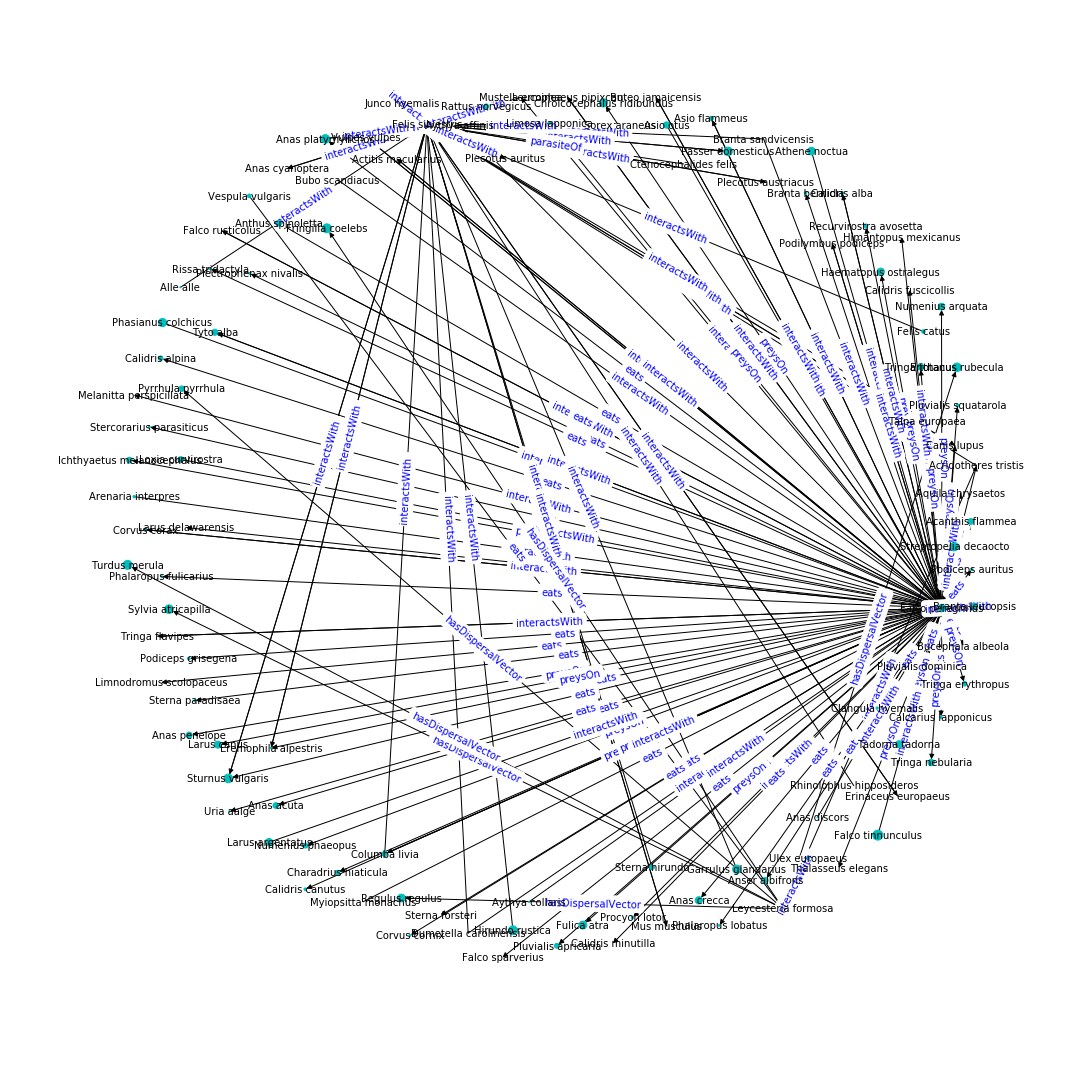

In [348]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
#pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [349]:
with open(taxon+country+".html", "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='../../../GitHub\cytoscape.js\dist\cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='../../../GitHub\cytoscape.js-cose-bilkent\cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [350]:
with open(taxon+country+".html", "a") as file:
    file.write("<table><th>Species</th><th>Occupancy</th>")
    

In [351]:
species = G.nodes
with open(taxon+country+".html", "a") as file:
    for n in species:
        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")
        #file.write("<a href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a>, "+str(dictOfNodeSizes[n])+"\n")

In [352]:
with open(taxon+country+".html", "a") as file:
    file.write("</table>")    
file.close()

In [353]:
with open(taxon+country+".html", "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [354]:
file = open(taxon+country+".html", "a")
for n in species:
    file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, },\n")
file.close()

### Write edges to file

In [355]:
file = open(taxon+country+".html", "a")
for edge in G.edges:
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [356]:
with open(taxon+country+".html", "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'darkgreen', \n\
                label: 'data(id)', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '12px', \n\
                'width': 'mapData(occnum, 0, 400, 3, 150)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 150)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '12px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
            },  \n\
            {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'background-color': 'red'  \n\
            }  \n\
        }], \n\
layout:  { \n\
            name: 'circle', padding: 10, animate: true, gravity: 30, animationDuration: 1000 \n\
     } \n\
} \n\
); \n\
cy.userZoomingEnabled( true ); \n\
</script> \n\
")

In [357]:
with open(taxon+country+".html", "a") as file:
    file.write("<h2>References</h2><ul>\n")

In [358]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
file = open(taxon+country+".html", "a")
for ref in citations:
    file.write("<li>"+str(ref)+"</li>\n")
file.close()

In [359]:
with open(taxon+country+".html", "a") as file:
    file.write("</ul> \
        </body> \
        </html>")

## Output a CSV file for import into Gephi

In [360]:
for node in G.edges:
    print(node[1])

Acridotheres tristis
Actitis macularius
Leucophaeus pipixcan
Falco rusticolus
Aquila chrysaetos
Podilymbus podiceps
Asio flammeus
Tyto alba
Vulpes vulpes
Canis lupus
Procyon lotor
Mustela erminea
Anas acuta
Calidris minutilla
Podiceps auritus
Limnodromus scolopaceus
Podiceps grisegena
Anas crecca
Bucephala albeola
Falco sparverius
Tringa flavipes
Phalaropus lobatus
Acanthis flammea
Plectrophenax nivalis
Calcarius lapponicus
Anas platyrhynchos
Anser albifrons
Corvus corax
Clangula hyemalis
Sterna paradisaea
Stercorarius parasiticus
Calidris fuscicollis
Pluvialis dominica
Calidris alpina
Anthus spinoletta
Eremophila alpestris
Columba livia
Uria aalge
Rissa tridactyla
Branta bernicla
Calidris alba
Sterna forsteri
Streptopelia decaocto
Larus delawarensis
Sturnus vulgaris
Corvus cornix
Pluvialis squatarola
Buteo jamaicensis
Phalaropus fulicarius
Melanitta perspicillata
Himantopus mexicanus
Fulica atra
Thalasseus elegans
Ichthyaetus melanocephalus
Anas penelope
Tadorna tadorna
Larus canus
Ch

In [361]:
with open(taxon+"_nodes.csv", "w") as file:
    file.write("Id,Label,Category")
    for node in G.nodes:
        file.write("'"+edge[0]+edge[1]+"','"+edge[0]+"','"+edge[1]+"','"+nx.get_edge_attributes(G, 'label')[edge]+"'\n")
file.close()

In [362]:
with open(taxon+"edges.csv", "w") as file:
    file.write("Id,Label,Category")
    for node in G.nodes:
        file.write("'"+edge[0]+edge[1]+"','"+edge[0]+"','"+edge[1]+"','"+nx.get_edge_attributes(G, 'label')[edge]+"'\n")
file.close()

In [363]:
#with open(taxon+".csv", "w") as file:
write_dot(G, taxon+".dot")